# DNN Training with All Data - Confidence vs Non-Confidence Comparison

This notebook trains DNN models using **all available data as training data**, comparing:
1. Standard DNN model (without confidence weighting)  
2. Confidence-weighted DNN model

The data preparation **does not use PCA** and treats all data as training data for maximum model learning potential, using the original high-dimensional features directly.

## Overview

This notebook trains DNN models using ALL available data for maximum learning potential. Unlike the standard train/test split approach, this version treats all data as training data to maximize the model's learning from the complete dataset.

The data preparation follows the same steps as the training_combined notebook but **does not use PCA** and treats all data as training data for maximum model learning potential.

### Key Features:
- **No dimensionality reduction**: Uses original high-dimensional features directly
- **All data training**: Uses complete dataset for training (no train/test split)
- **Two model types**: Standard DNN and confidence-weighted DNN
- **External evaluation**: Tests on separate acinar dataset for generalization assessment

### Models Trained:
1. **Standard DNN**: Traditional training without confidence weighting
2. **Confidence-weighted DNN**: Training with patch confidence scores as sample weights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import warnings
import sys

# Add current directory to path to import local modules
current_dir = os.path.dirname(os.path.abspath('.'))
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Import local model builders
from model_builder import create_dnn_model
from model_builder_with_conf import create_dnn_model as create_dnn_model_conf

warnings.filterwarnings('ignore')

## Load and Prepare Dataset

Configure settings and load the datasets for both standard and confidence-weighted training.

In [2]:
# Configuration parameters
embedding_dim = 1536  # UNI embedding dimension
epochs = 30  # Training epochs

# Define paths
output_base_path = "results/all_data_training"
result_subfolder = "all_data_training"

# Create output directory if it doesn't exist
os.makedirs(output_base_path, exist_ok=True)

# Input CSV files
input_csv_standard = "training_data/WSI_patch_embeddings_centered-448_adenocarcinoma_leiden_0.3_training-data.csv"
input_csv_confidence = "training_data/WSI_patch_embeddings_standard-448_adenocarcinoma_leiden_0.3_training-data.csv"

print("=== CONFIGURATION SUMMARY ===")
print(f"Embedding dimension: {embedding_dim}")
print(f"Training epochs: {epochs}")
print(f"Output path: {output_base_path}")
print(f"Result folder: {result_subfolder}")

# Load standard dataset (for non-confidence training)
print(f"\n=== LOADING STANDARD DATASET ===")
df_standard = pd.read_csv(input_csv_standard)
print(f"Standard dataset shape: {df_standard.shape}")
print(f"Standard dataset columns: {df_standard.columns.tolist()}")

# Load confidence dataset (for confidence-weighted training)
print(f"\n=== LOADING CONFIDENCE DATASET ===")
df_confidence = pd.read_csv(input_csv_confidence)
print(f"Confidence dataset shape: {df_confidence.shape}")
print(f"Confidence dataset columns: {df_confidence.columns.tolist()}")

=== CONFIGURATION SUMMARY ===
Embedding dimension: 1536
Training epochs: 30
Output path: results/all_data_training
Result folder: all_data_training

=== LOADING STANDARD DATASET ===
Standard dataset shape: (4371, 1539)
Standard dataset columns: ['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '1

## Feature Processing

**This script has been modified to use original high-dimensional features directly.**

No dimensionality reduction (PCA) is applied. The models will train on the full 1536-dimensional feature space for maximum information retention.

In [3]:
# Extract and preprocess standard dataset (all data as training)
print("=== PREPROCESSING STANDARD DATASET ===")
feature_cols = [str(i) for i in range(embedding_dim)]
X_standard = df_standard[feature_cols].values.astype(np.float32)

# Standardize features
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X_standard).astype(np.float32)

# Encode labels
labelEncoder_standard = LabelEncoder()
y_standard = labelEncoder_standard.fit_transform(df_standard['label'].values).astype(np.int64)

print(f"Standard dataset - Features shape: {X_standard.shape}")
print(f"Standard dataset - Labels shape: {y_standard.shape}")
print(f"Standard dataset - Unique labels: {labelEncoder_standard.classes_}")
print(f"Standard dataset - Label distribution:")
unique_labels_std, counts_std = np.unique(y_standard, return_counts=True)
for label_idx, count in zip(unique_labels_std, counts_std):
    label_name = labelEncoder_standard.classes_[label_idx]
    print(f"  {label_name}: {count} samples")

# Extract and preprocess confidence dataset (all data as training)
print(f"\n=== PREPROCESSING CONFIDENCE DATASET ===")
feature_cols_conf = [str(i) for i in range(embedding_dim)]
X_confidence = df_confidence[feature_cols_conf].values.astype(np.float32)

# Standardize features
scaler_confidence = StandardScaler()
X_confidence = scaler_confidence.fit_transform(X_confidence).astype(np.float32)

# Encode labels
labelEncoder_confidence = LabelEncoder()
y_confidence = labelEncoder_confidence.fit_transform(df_confidence['label'].values).astype(np.int64)

# Extract confidence scores
confidence_scores = df_confidence['confidence'].values.astype(np.float32)

print(f"Confidence dataset - Features shape: {X_confidence.shape}")
print(f"Confidence dataset - Labels shape: {y_confidence.shape}")
print(f"Confidence dataset - Confidence scores shape: {confidence_scores.shape}")
print(f"Confidence dataset - Unique labels: {labelEncoder_confidence.classes_}")
print(f"Confidence dataset - Label distribution:")
unique_labels_conf, counts_conf = np.unique(y_confidence, return_counts=True)
for label_idx, count in zip(unique_labels_conf, counts_conf):
    label_name = labelEncoder_confidence.classes_[label_idx]
    print(f"  {label_name}: {count} samples")

print(f"\nConfidence scores statistics:")
print(f"  Mean: {confidence_scores.mean():.3f}")
print(f"  Std: {confidence_scores.std():.3f}")
print(f"  Min: {confidence_scores.min():.3f}")
print(f"  Max: {confidence_scores.max():.3f}")

=== PREPROCESSING STANDARD DATASET ===
Standard dataset - Features shape: (4371, 1536)
Standard dataset - Labels shape: (4371,)
Standard dataset - Unique labels: [0 1 2 3 4 5 6]
Standard dataset - Label distribution:
  0: 1229 samples
  1: 925 samples
  2: 900 samples
  3: 666 samples
  4: 356 samples
  5: 261 samples
  6: 34 samples

=== PREPROCESSING CONFIDENCE DATASET ===
Confidence dataset - Features shape: (1644, 1536)
Confidence dataset - Labels shape: (1644,)
Confidence dataset - Confidence scores shape: (1644,)
Confidence dataset - Unique labels: [0 1 2 3 4 5 6]
Confidence dataset - Label distribution:
  0: 457 samples
  1: 338 samples
  2: 341 samples
  3: 258 samples
  4: 135 samples
  5: 99 samples
  6: 16 samples

Confidence scores statistics:
  Mean: 0.637
  Std: 0.207
  Min: 0.025
  Max: 1.000


## Feature Processing

The models will train on the original high-dimensional features without any dimensionality reduction.

In [4]:
# Using original features without PCA transformation
print("=== USING ORIGINAL FEATURES (NO PCA) ===")
print(f"Standard dataset will use original features:")
print(f"  Shape: {X_standard.shape}")
print(f"  Feature dimensions: {X_standard.shape[1]}")

print(f"\nConfidence dataset will use original features:")
print(f"  Shape: {X_confidence.shape}")
print(f"  Feature dimensions: {X_confidence.shape[1]}")

print(f"\n=== FEATURE SUMMARY ===")
print(f"Both datasets will use original high-dimensional features")
print(f"Standard dataset: {X_standard.shape[1]} features")
print(f"Confidence dataset: {X_confidence.shape[1]} features")
print(f"Ready for DNN training with full feature space!")

=== USING ORIGINAL FEATURES (NO PCA) ===
Standard dataset will use original features:
  Shape: (4371, 1536)
  Feature dimensions: 1536

Confidence dataset will use original features:
  Shape: (1644, 1536)
  Feature dimensions: 1536

=== FEATURE SUMMARY ===
Both datasets will use original high-dimensional features
Standard dataset: 1536 features
Confidence dataset: 1536 features
Ready for DNN training with full feature space!


## Train DNN Model without Confidence Weighting

Train a standard DNN model using all available data without confidence weighting, using the original high-dimensional features.

In [5]:
# Train standard DNN model (using all data, no PCA)
print("=== TRAINING STANDARD DNN MODEL ===")
print(f"Using ALL {X_standard.shape[0]} samples as training data")
print(f"Input dimensions: {X_standard.shape[1]} (original features)")
print(f"Number of classes: {len(labelEncoder_standard.classes_)}")
print(f"Training epochs: {epochs}")

# Create output path for standard DNN model
dnn_standard_output_path = f"{output_base_path}/dnn_standard_no_pca.pth"

# Train standard DNN model using all data
# Note: Since we're using all data for training, we use the same data for validation
# This is intentional as we want to maximize learning from all available data
dnn_standard_model, training_accuracy = create_dnn_model(
    X_standard,               # Training data (all data)
    X_standard,               # Validation data (same as training - all data)
    y_standard,               # Training labels (all data)
    y_standard,               # Validation labels (same as training - all data)
    dnn_standard_output_path, # Model save path
    labelEncoder_standard,    # Label encoder
    inputDim=embedding_dim,   # Original dimensions
    epochs=epochs
)

print(f"✓ Standard DNN model training completed!")
print(f"✓ Training accuracy: {training_accuracy:.3f}")
print(f"✓ Model saved to: {dnn_standard_output_path}")

print(f"\n=== STANDARD TRAINING SUMMARY ===")
print(f"✓ Trained standard DNN model:")
print(f"  Model path: {dnn_standard_output_path}")
print(f"  Features: {embedding_dim} (original dimensions)")
print(f"  Training accuracy: {training_accuracy:.3f}")
print(f"✓ Model trained on ALL available data ({X_standard.shape[0]} samples)")

=== TRAINING STANDARD DNN MODEL ===
Using ALL 4371 samples as training data
Input dimensions: 1536 (original features)
Number of classes: 7
Training epochs: 30
DNN: Epoch 1 completed. Average Loss: 0.6606
DNN: Epoch 1 completed. Average Loss: 0.6606
DNN: Epoch 2 completed. Average Loss: 0.4091
DNN: Epoch 2 completed. Average Loss: 0.4091
DNN: Epoch 3 completed. Average Loss: 0.3561
DNN: Epoch 3 completed. Average Loss: 0.3561
DNN: Epoch 4 completed. Average Loss: 0.3091
DNN: Epoch 4 completed. Average Loss: 0.3091
DNN: Epoch 5 completed. Average Loss: 0.2711
DNN: Epoch 5 completed. Average Loss: 0.2711
DNN: Epoch 6 completed. Average Loss: 0.2651
DNN: Epoch 6 completed. Average Loss: 0.2651
DNN: Epoch 7 completed. Average Loss: 0.2351
DNN: Epoch 7 completed. Average Loss: 0.2351
DNN: Epoch 8 completed. Average Loss: 0.2169
DNN: Epoch 8 completed. Average Loss: 0.2169
DNN: Epoch 9 completed. Average Loss: 0.2115
DNN: Epoch 9 completed. Average Loss: 0.2115
DNN: Epoch 10 completed. Avera

## Train DNN Model with Confidence Weighting

Train a confidence-weighted DNN model using all available data with confidence scores, using the original high-dimensional features.

In [6]:
# Train confidence-weighted DNN model (using all data, no PCA)
print("=== TRAINING CONFIDENCE-WEIGHTED DNN MODEL ===")
print(f"Using ALL {X_confidence.shape[0]} samples as training data")
print(f"Input dimensions: {X_confidence.shape[1]} (original features)")
print(f"Number of classes: {len(labelEncoder_confidence.classes_)}")
print(f"Training epochs: {epochs}")

# Create output path for confidence-weighted DNN model
dnn_confidence_output_path = f"{output_base_path}/dnn_confidence_no_pca.pth"

# Extract confidence values and use them as sample weights
# Use the 'confidence' column that was extracted during preprocessing
confidence_weights = confidence_scores.copy()  # Use the confidence_scores already extracted in preprocessing

print(f"Confidence weight statistics:")
print(f"  Min: {confidence_weights.min():.3f}")
print(f"  Max: {confidence_weights.max():.3f}")
print(f"  Mean: {confidence_weights.mean():.3f}")
print(f"  Std: {confidence_weights.std():.3f}")
print(f"Training DNN with confidence-based sample weights")

# Train confidence-weighted DNN model using all data
# Note: Since we're using all data for training, we use the same data for validation
# This is intentional as we want to maximize learning from all available data
dnn_confidence_model, training_accuracy = create_dnn_model_conf(
    X_confidence,              # Training data (all data)
    X_confidence,              # Validation data (same as training - all data)
    y_confidence,              # Training labels (all data)
    y_confidence,              # Validation labels (same as training - all data)
    dnn_confidence_output_path, # Model save path
    labelEncoder_confidence,   # Label encoder
    embedding_dim,             # Input dimensions (positional argument)
    epochs,                    # Epochs (positional argument)
    0.5,                       # Dropout probability
    confidence_weights,        # Training weights (confidence values)
    confidence_weights         # Validation weights (same as training - all data)
)

print(f"✓ Confidence-weighted DNN model training completed!")
print(f"✓ Training accuracy: {training_accuracy:.3f}")
print(f"✓ Model saved to: {dnn_confidence_output_path}")

print(f"\n=== CONFIDENCE-WEIGHTED TRAINING SUMMARY ===")
print(f"✓ Trained confidence-weighted DNN model:")
print(f"  Model path: {dnn_confidence_output_path}")
print(f"  Features: {embedding_dim} (original dimensions)")
print(f"  Training accuracy: {training_accuracy:.3f}")
print(f"  Sample weights: confidence-based (mean: {confidence_weights.mean():.3f})")
print(f"✓ Model trained on ALL available data ({X_confidence.shape[0]} samples)")
print(f"✓ Used actual confidence scores from 'confidence' column: {confidence_weights.min():.3f} to {confidence_weights.max():.3f}")

=== TRAINING CONFIDENCE-WEIGHTED DNN MODEL ===
Using ALL 1644 samples as training data
Input dimensions: 1536 (original features)
Number of classes: 7
Training epochs: 30
Confidence weight statistics:
  Min: 0.025
  Max: 1.000
  Mean: 0.637
  Std: 0.207
Training DNN with confidence-based sample weights
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.5935
DNN: Epoch 2 completed. Average Loss: 0.3532
DNN: Epoch 1 completed. Average Loss: 0.5935
DNN: Epoch 2 completed. Average Loss: 0.3532
DNN: Epoch 3 completed. Average Loss: 0.2880
DNN: Epoch 4 completed. Average Loss: 0.2534
DNN: Epoch 3 completed. Average Loss: 0.2880
DNN: Epoch 4 completed. Average Loss: 0.2534
DNN: Epoch 5 completed. Average Loss: 0.2109
DNN: Epoch 6 completed. Average Loss: 0.1987
DNN: Epoch 5 completed. Average Loss: 0.2109
DNN: Epoch 6 completed. Average Loss: 0.1987
DNN: Epoch 7 completed. Average Loss: 0.1701
DNN: Epoch 8 completed. Average Loss: 0.1624
DNN: Epoch 7 com

## External Evaluation on Acinar Dataset

Evaluate both trained models on the external acinar dataset to test generalization performance and calculate similarity scores between predicted and actual labels despite naming differences.

In [7]:
# Load external evaluation dataset
print("=== LOADING EXTERNAL EVALUATION DATASET ===")
eval_csv_path = "training_data/WSI_patch_embeddings_centered-448_acinar_leiden_0.3_training-data.csv"
df_eval = pd.read_csv(eval_csv_path)

print(f"Evaluation dataset shape: {df_eval.shape}")
print(f"Evaluation dataset columns: {df_eval.columns.tolist()}")

# Check the label distribution in the evaluation dataset
print(f"\nEvaluation dataset label distribution:")
eval_label_counts = df_eval['label'].value_counts()
print(eval_label_counts)

print(f"\nUnique labels in evaluation dataset: {sorted(df_eval['label'].unique())}")

# Extract features for evaluation
print(f"\n=== PREPARING EVALUATION DATA ===")

# Extract feature columns (0 to 1535) - same as training data
eval_feature_cols = [col for col in df_eval.columns if col.isdigit()]
eval_embedding_dim = len(eval_feature_cols)

print(f"Evaluation dataset embedding dimension: {eval_embedding_dim}")
print(f"Training models embedding dimension: {embedding_dim}")

# Verify dimensions match (both should be 1536)
if eval_embedding_dim == embedding_dim:
    print(f"✓ Dimensions match perfectly!")
    print(f"  Both evaluation and training data have {embedding_dim} feature dimensions (0-1535)")
    
    # Extract features directly - no adjustment needed
    X_eval = df_eval[eval_feature_cols].values.astype(np.float32)
    print(f"✓ Using all {X_eval.shape[1]} feature columns directly")
else:
    # This should not happen based on verification, but keeping as safety check
    print(f"⚠️  Unexpected dimension mismatch!")
    print(f"   Evaluation data: {eval_embedding_dim} dimensions")
    print(f"   Training models: {embedding_dim} dimensions")
    
    # Use the minimum of both to avoid errors
    min_dims = min(eval_embedding_dim, embedding_dim)
    feature_cols_safe = [str(i) for i in range(min_dims)]
    X_eval = df_eval[feature_cols_safe].values.astype(np.float32)
    print(f"   Using first {min_dims} dimensions for safety")

print(f"Final evaluation features shape: {X_eval.shape}")

# Extract evaluation labels
y_eval = df_eval['label'].values
print(f"Evaluation labels shape: {y_eval.shape}")
print(f"Evaluation labels: {sorted(set(y_eval))}")

=== LOADING EXTERNAL EVALUATION DATASET ===
Evaluation dataset shape: (3043, 1539)
Evaluation dataset columns: ['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '13

In [8]:
# Standardize evaluation data using the same scalers from training
print("=== STANDARDIZING EVALUATION DATA ===")

# Use the scaler from standard training data
X_eval_std = scaler_standard.transform(X_eval).astype(np.float32)
print(f"✓ Applied standard scaler to evaluation data")

# For confidence-weighted models, we also need to transform using the confidence scaler
X_eval_conf = scaler_confidence.transform(X_eval).astype(np.float32)
print(f"✓ Applied confidence scaler to evaluation data")

print(f"\n✓ Evaluation data preprocessed and ready for prediction:")
print(f"  Standard data: {X_eval_std.shape} (original features)")
print(f"  Confidence data: {X_eval_conf.shape} (original features)")
print(f"Both models will use the full {X_eval.shape[1]}-dimensional feature space")

=== STANDARDIZING EVALUATION DATA ===
✓ Applied standard scaler to evaluation data
✓ Applied confidence scaler to evaluation data

✓ Evaluation data preprocessed and ready for prediction:
  Standard data: (3043, 1536) (original features)
  Confidence data: (3043, 1536) (original features)
Both models will use the full 1536-dimensional feature space


In [9]:
# Make predictions with trained models (no PCA versions only)
print("=== MAKING PREDICTIONS ON EVALUATION DATA ===")

# Define label mappings from encoders
original_labels_std = labelEncoder_standard.classes_.tolist()
original_labels_conf = labelEncoder_confidence.classes_.tolist()

print(f"Standard model labels: {original_labels_std}")
print(f"Confidence model labels: {original_labels_conf}")

# 1. Standard DNN (no PCA) predictions
print("\n1. Standard DNN:")
X_eval_std_tensor = torch.tensor(X_eval_std).float()
with torch.no_grad():
    std_eval_outputs = dnn_standard_model(X_eval_std_tensor)
    std_eval_predictions = F.softmax(std_eval_outputs, dim=1).argmax(dim=1)

std_eval_labels = [original_labels_std[idx] for idx in std_eval_predictions.numpy()]
print(f"   Predicted {len(std_eval_labels)} labels")
print(f"   Unique predictions: {sorted(set(std_eval_labels))}")

# 2. Confidence-weighted DNN (no PCA) predictions
print("\n2. Confidence-weighted DNN:")
X_eval_conf_tensor = torch.tensor(X_eval_conf).float()
with torch.no_grad():
    conf_eval_outputs = dnn_confidence_model(X_eval_conf_tensor)
    conf_eval_predictions = F.softmax(conf_eval_outputs, dim=1).argmax(dim=1)

conf_eval_labels = [original_labels_conf[idx] for idx in conf_eval_predictions.numpy()]
print(f"   Predicted {len(conf_eval_labels)} labels")
print(f"   Unique predictions: {sorted(set(conf_eval_labels))}")

print(f"\n=== PREDICTION SUMMARY ===")
print(f"Standard model predictions: {sorted(set(std_eval_labels))}")
print(f"Confidence model predictions: {sorted(set(conf_eval_labels))}")
print(f"Evaluation dataset labels: {sorted(set(y_eval))}")

print(f"\n✓ Ready for cross-domain cluster similarity analysis")
print(f"✓ Both models trained on original high-dimensional features ({embedding_dim} dimensions)")

=== MAKING PREDICTIONS ON EVALUATION DATA ===
Standard model labels: [0, 1, 2, 3, 4, 5, 6]
Confidence model labels: [0, 1, 2, 3, 4, 5, 6]

1. Standard DNN:
   Predicted 3043 labels
   Unique predictions: [0, 1, 2, 3, 4, 5]

2. Confidence-weighted DNN:
   Predicted 3043 labels
   Unique predictions: [0, 1, 2, 3, 4, 5]

=== PREDICTION SUMMARY ===
Standard model predictions: [0, 1, 2, 3, 4, 5]
Confidence model predictions: [0, 1, 2, 3, 4, 5]
Evaluation dataset labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

✓ Ready for cross-domain cluster similarity analysis
✓ Both models trained on original high-dimensional features (1536 dimensions)


In [10]:
# Cross-Domain Cluster Similarity Analysis
print("=== CROSS-DOMAIN CLUSTER SIMILARITY ANALYSIS ===")
print("NOTE: Training data (adenocarcinoma) and evaluation data (acinar) have different")
print("      biological contexts. Cluster labels 0,1,2... are NOT comparable across datasets.")
print("      This analysis focuses on cluster distribution patterns and assignment quality.")

from difflib import SequenceMatcher
from collections import Counter
import numpy as np
from scipy import stats
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score

def calculate_cross_domain_cluster_similarity(actual_labels, predicted_labels):
    """
    Calculate cross-domain cluster similarity metrics for cases where
    actual and predicted labels come from different biological contexts
    and cluster labels have no direct correspondence.
    """
    # Ensure all labels are strings for consistent processing
    actual_labels = [str(label) for label in actual_labels]
    predicted_labels = [str(label) for label in predicted_labels]
    
    actual_unique = sorted(set(actual_labels))
    predicted_unique = sorted(set(predicted_labels))
    
    print(f"Actual clusters ({len(actual_unique)}): {actual_unique}")
    print(f"Predicted clusters ({len(predicted_unique)}): {predicted_unique}")
    
    # 1. Cluster Count Similarity
    cluster_count_similarity = min(len(actual_unique), len(predicted_unique)) / max(len(actual_unique), len(predicted_unique))
    
    # 2. Distribution Shape Similarity (using statistical tests)
    actual_dist = Counter(actual_labels)
    predicted_dist = Counter(predicted_labels)
    
    # Normalize distributions
    total_actual = sum(actual_dist.values())
    total_predicted = sum(predicted_dist.values())
    
    actual_probs = np.array([actual_dist.get(str(i), 0) / total_actual for i in range(max(len(actual_unique), len(predicted_unique)))])
    predicted_probs = np.array([predicted_dist.get(str(i), 0) / total_predicted for i in range(max(len(actual_unique), len(predicted_unique)))])
    
    # Jensen-Shannon divergence for distribution similarity
    from scipy.spatial.distance import jensenshannon
    js_divergence = jensenshannon(actual_probs, predicted_probs)
    distribution_shape_similarity = 1 - js_divergence
    
    # 3. Optimal Assignment using Hungarian Algorithm
    # Create a cost matrix based on population overlaps when optimally assigned
    from scipy.optimize import linear_sum_assignment
    
    # Build cost matrix (negative overlap for minimization)
    cost_matrix = np.zeros((len(actual_unique), len(predicted_unique)))
    
    for i, actual_cluster in enumerate(actual_unique):
        for j, pred_cluster in enumerate(predicted_unique):
            # Count overlapping samples if we assign actual_cluster to pred_cluster
            overlap = sum(1 for a, p in zip(actual_labels, predicted_labels) 
                         if a == actual_cluster and p == pred_cluster)
            cost_matrix[i, j] = -overlap  # Negative for minimization
    
    # Find optimal assignment
    if cost_matrix.size > 0:
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        optimal_overlap = -cost_matrix[row_indices, col_indices].sum()
        optimal_accuracy = optimal_overlap / len(actual_labels)
        
        # Create optimal mapping
        optimal_mapping = {}
        for i, j in zip(row_indices, col_indices):
            optimal_mapping[actual_unique[i]] = predicted_unique[j]
    else:
        optimal_accuracy = 0.0
        optimal_mapping = {}
    
    # 4. Cluster Quality Metrics
    # Entropy-based measures
    actual_entropy = stats.entropy([actual_dist[k] for k in actual_unique])
    predicted_entropy = stats.entropy([predicted_dist[k] for k in predicted_unique])
    entropy_similarity = 1 - abs(actual_entropy - predicted_entropy) / max(actual_entropy, predicted_entropy)
    
    # 5. Mutual Information (how much info predicted clusters give about actual clusters)
    try:
        # Convert to numeric for sklearn metrics
        actual_numeric = [actual_unique.index(label) for label in actual_labels]
        predicted_numeric = [predicted_unique.index(label) for label in predicted_labels]
        
        mutual_info = normalized_mutual_info_score(actual_numeric, predicted_numeric)
        adjusted_mutual_info = adjusted_mutual_info_score(actual_numeric, predicted_numeric)
    except:
        mutual_info = 0.0
        adjusted_mutual_info = 0.0
    
    print(f"\n=== CROSS-DOMAIN SIMILARITY RESULTS ===")
    print(f"Cluster Count Similarity: {cluster_count_similarity:.4f}")
    print(f"Distribution Shape Similarity: {distribution_shape_similarity:.4f}")
    print(f"Optimal Assignment Accuracy: {optimal_accuracy:.4f}")
    print(f"Entropy Similarity: {entropy_similarity:.4f}")
    print(f"Normalized Mutual Information: {mutual_info:.4f}")
    print(f"Adjusted Mutual Information: {adjusted_mutual_info:.4f}")
    
    print(f"\nOptimal cluster assignment:")
    for actual, predicted in optimal_mapping.items():
        actual_count = actual_dist[actual]
        pred_count = predicted_dist[predicted]
        overlap = sum(1 for a, p in zip(actual_labels, predicted_labels) 
                     if a == actual and p == predicted)
        print(f"  Acinar cluster {actual} → Predicted cluster {predicted}")
        print(f"    Acinar samples: {actual_count}, Predicted samples: {pred_count}, Overlap: {overlap}")
    
    return {
        'cluster_count_similarity': cluster_count_similarity,
        'distribution_shape_similarity': distribution_shape_similarity,
        'optimal_assignment_accuracy': optimal_accuracy,
        'entropy_similarity': entropy_similarity,
        'normalized_mutual_info': mutual_info,
        'adjusted_mutual_info': adjusted_mutual_info,
        'optimal_mapping': optimal_mapping,
        'actual_distribution': actual_dist,
        'predicted_distribution': predicted_dist,
        # Legacy fields for compatibility
        'exact_match_ratio': 0.0,  # Not meaningful in cross-domain
        'mapped_accuracy': optimal_accuracy,  # Use optimal assignment
        'distribution_similarity': distribution_shape_similarity,
        'label_mapping': optimal_mapping,
        'similarity_scores': {k: 1.0 for k in optimal_mapping.keys()}
    }

# Import scipy for advanced metrics and optimization
try:
    from scipy.spatial.distance import jensenshannon
    from scipy.optimize import linear_sum_assignment
    from scipy import stats
    from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score
except ImportError:
    print("Installing required packages for advanced similarity metrics...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scipy', 'scikit-learn'])
    from scipy.spatial.distance import jensenshannon
    from scipy.optimize import linear_sum_assignment
    from scipy import stats
    from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score

print("Calculating cross-domain cluster similarity for all models...\n")
print("IMPORTANT: This analysis treats cluster labels as domain-specific identifiers")
print("and focuses on clustering quality and pattern similarity across domains.\n")

=== CROSS-DOMAIN CLUSTER SIMILARITY ANALYSIS ===
NOTE: Training data (adenocarcinoma) and evaluation data (acinar) have different
      biological contexts. Cluster labels 0,1,2... are NOT comparable across datasets.
      This analysis focuses on cluster distribution patterns and assignment quality.
Calculating cross-domain cluster similarity for all models...

IMPORTANT: This analysis treats cluster labels as domain-specific identifiers
and focuses on clustering quality and pattern similarity across domains.



In [11]:
# Calculate cross-domain cluster similarity for trained models
eval_results = {}

# Ensure we use string labels for evaluation (y_eval should already be strings)
y_eval_strings = [str(label) for label in y_eval]

# 1. Standard DNN (no PCA)
print("=== EVALUATING STANDARD DNN ===")
eval_results['std_no_pca'] = calculate_cross_domain_cluster_similarity(y_eval_strings, std_eval_labels)

# 2. Confidence-weighted DNN (no PCA)
print("\n=== EVALUATING CONFIDENCE-WEIGHTED DNN ===")
eval_results['conf_no_pca'] = calculate_cross_domain_cluster_similarity(y_eval_strings, conf_eval_labels)

# Create comprehensive comparison
print("\n" + "="*80)
print("COMPREHENSIVE CROSS-DOMAIN EVALUATION RESULTS COMPARISON")
print("="*80)

comparison_data = []
for model_name, results in eval_results.items():
    model_display_name = model_name.replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
    comparison_data.append({
        'Model': model_display_name,
        'Optimal Assignment Accuracy': f"{results['optimal_assignment_accuracy']:.4f}",
        'Distribution Shape Similarity': f"{results['distribution_shape_similarity']:.4f}",
        'Cluster Count Similarity': f"{results['cluster_count_similarity']:.4f}",
        'Entropy Similarity': f"{results['entropy_similarity']:.4f}",
        'Normalized Mutual Info': f"{results['normalized_mutual_info']:.4f}",
        'Adjusted Mutual Info': f"{results['adjusted_mutual_info']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nSummary of All Models:")
print(comparison_df.to_string(index=False))

# Find best performing model for each metric
print(f"\n" + "="*50)
print("BEST PERFORMING MODELS BY METRIC")
print("="*50)

metrics = ['optimal_assignment_accuracy', 'distribution_shape_similarity', 'normalized_mutual_info', 'entropy_similarity']
for metric in metrics:
    best_model = max(eval_results.items(), key=lambda x: x[1][metric])
    model_display_name = best_model[0].replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
    print(f"{metric.replace('_', ' ').title()}: {model_display_name} ({best_model[1][metric]:.4f})")

# Overall best model (weighted average of metrics) 
print(f"\nOVERALL BEST MODEL (weighted average):")
overall_scores = {}
for model_name, results in eval_results.items():
    # Weight: 40% optimal assignment, 30% distribution similarity, 20% mutual info, 10% entropy similarity
    weighted_score = (0.4 * results['optimal_assignment_accuracy'] + 
                     0.3 * results['distribution_shape_similarity'] + 
                     0.2 * results['normalized_mutual_info'] + 
                     0.1 * results['entropy_similarity'])
    overall_scores[model_name] = weighted_score

best_overall = max(overall_scores.items(), key=lambda x: x[1])
best_model_display_name = best_overall[0].replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
print(f"{best_model_display_name}: {best_overall[1]:.4f}")

print(f"\nWeighted scores for all models:")
for model, score in sorted(overall_scores.items(), key=lambda x: x[1], reverse=True):
    model_display_name = model.replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
    print(f"  {model_display_name}: {score:.4f}")

=== EVALUATING STANDARD DNN ===
Actual clusters (6): ['0', '1', '2', '3', '4', '5']
Predicted clusters (6): ['0', '1', '2', '3', '4', '5']

=== CROSS-DOMAIN SIMILARITY RESULTS ===
Cluster Count Similarity: 1.0000
Distribution Shape Similarity: 0.6163
Optimal Assignment Accuracy: 0.3953
Entropy Similarity: 0.9300
Normalized Mutual Information: 0.1091
Adjusted Mutual Information: 0.1064

Optimal cluster assignment:
  Acinar cluster 0 → Predicted cluster 1
    Acinar samples: 1307, Predicted samples: 850, Overlap: 495
  Acinar cluster 1 → Predicted cluster 0
    Acinar samples: 648, Predicted samples: 647, Overlap: 329
  Acinar cluster 2 → Predicted cluster 4
    Acinar samples: 597, Predicted samples: 1148, Overlap: 350
  Acinar cluster 3 → Predicted cluster 2
    Acinar samples: 246, Predicted samples: 5, Overlap: 0
  Acinar cluster 4 → Predicted cluster 3
    Acinar samples: 205, Predicted samples: 375, Overlap: 29
  Acinar cluster 5 → Predicted cluster 5
    Acinar samples: 40, Predic

In [12]:
# Detailed analysis and save results
print("\n" + "="*80)
print("DETAILED CROSS-DOMAIN CLUSTER ASSIGNMENT ANALYSIS")
print("="*80)

# Show detailed mapping for the best performing model
best_model_name = best_overall[0]
best_results = eval_results[best_model_name]

best_model_display_name = best_model_name.replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
print(f"\nBest performing model: {best_model_display_name}")
print(f"Optimal cluster assignment (Acinar → Predicted):")

for actual_label, mapped_label in best_results['optimal_mapping'].items():
    actual_count = best_results['actual_distribution'][actual_label]
    mapped_count = best_results['predicted_distribution'].get(mapped_label, 0)
    
    # Calculate overlap for this specific assignment
    # Determine which predictions to use based on best model
    if best_model_name == 'std_no_pca':
        predictions_to_use = std_eval_labels
    else:  # conf_no_pca
        predictions_to_use = conf_eval_labels
        
    overlap = sum(1 for a, p in zip(y_eval_strings, predictions_to_use) 
                 if a == actual_label and p == mapped_label)
    
    assignment_quality = overlap / actual_count if actual_count > 0 else 0
    
    print(f"  Acinar cluster {actual_label} → Predicted cluster {mapped_label}")
    print(f"    Acinar samples: {actual_count}, Predicted samples: {mapped_count}")
    print(f"    Correctly assigned: {overlap} ({assignment_quality:.3f})")

# Create confusion matrix for best model
print(f"\n" + "="*50)
print("CLUSTER ASSIGNMENT QUALITY ANALYSIS (Best Model)")
print("="*50)

# Get the actual predictions for the best model
if best_model_name == 'std_no_pca':
    best_predictions = std_eval_labels
else:  # conf_no_pca
    best_predictions = conf_eval_labels

# Calculate per-cluster assignment quality
unique_actual = sorted(set(y_eval))
confusion_data = []

for actual_label in unique_actual:
    actual_indices = [i for i, label in enumerate(y_eval) if label == actual_label]
    predicted_for_actual = [best_predictions[i] for i in actual_indices]
    predicted_counts = Counter(predicted_for_actual)
    
    # Find the optimal assignment for this cluster
    optimal_pred = best_results['optimal_mapping'].get(str(actual_label), 'UNKNOWN')
    optimal_count = predicted_counts.get(optimal_pred, 0)
    
    total_actual = len(actual_indices)
    assignment_quality = optimal_count / total_actual if total_actual > 0 else 0
    
    confusion_data.append({
        'Acinar_Cluster': actual_label,
        'Optimal_Predicted_Cluster': optimal_pred,
        'Total_Acinar_Samples': total_actual,
        'Correctly_Assigned': optimal_count,
        'Assignment_Quality': assignment_quality,
        'All_Predictions': dict(predicted_counts)
    })

# Create confusion matrix DataFrame
confusion_df = pd.DataFrame(confusion_data)
print(confusion_df[['Acinar_Cluster', 'Optimal_Predicted_Cluster', 'Total_Acinar_Samples', 
                   'Correctly_Assigned', 'Assignment_Quality']].to_string(index=False))

# Save detailed results to CSV
print(f"\n" + "="*50)
print("SAVING DETAILED EVALUATION RESULTS")
print("="*50)

# Create results directory
os.makedirs(f"results/{result_subfolder}", exist_ok=True)

# Save comprehensive evaluation results
eval_results_path = f"results/{result_subfolder}/cross_domain_evaluation_results.csv"
detailed_results = []

for model_name, results in eval_results.items():
    model_display_name = model_name.replace('_no_pca', '').replace('std', 'Standard DNN').replace('conf', 'Confidence-weighted DNN')
    detailed_results.append({
        'model_name': model_display_name,
        'model_type': 'Standard DNN' if 'std' in model_name else 'Confidence-weighted DNN',
        'optimal_assignment_accuracy': results['optimal_assignment_accuracy'],
        'distribution_shape_similarity': results['distribution_shape_similarity'],
        'cluster_count_similarity': results['cluster_count_similarity'],
        'entropy_similarity': results['entropy_similarity'],
        'normalized_mutual_info': results['normalized_mutual_info'],
        'adjusted_mutual_info': results['adjusted_mutual_info'],
        'weighted_overall_score': overall_scores[model_name],
        'training_domain': 'adenocarcinoma',
        'evaluation_domain': 'acinar',
        'training_clusters': 7,
        'evaluation_clusters': len(set(y_eval)),
        'evaluation_dataset': eval_csv_path,
        'evaluation_samples': len(y_eval),
        'acinar_clusters': len(set(y_eval)),
        'predicted_clusters': len(set(best_predictions)) if model_name == best_model_name else 'N/A',
        'evaluation_type': 'cross_domain_cluster_analysis',
        'pca_used': False
    })

pd.DataFrame(detailed_results).to_csv(eval_results_path, index=False)
print(f"✓ Detailed cross-domain evaluation results saved to: {eval_results_path}")


DETAILED CROSS-DOMAIN CLUSTER ASSIGNMENT ANALYSIS

Best performing model: Standard DNN
Optimal cluster assignment (Acinar → Predicted):
  Acinar cluster 0 → Predicted cluster 1
    Acinar samples: 1307, Predicted samples: 850
    Correctly assigned: 0 (0.000)
  Acinar cluster 1 → Predicted cluster 0
    Acinar samples: 648, Predicted samples: 647
    Correctly assigned: 0 (0.000)
  Acinar cluster 2 → Predicted cluster 4
    Acinar samples: 597, Predicted samples: 1148
    Correctly assigned: 0 (0.000)
  Acinar cluster 3 → Predicted cluster 2
    Acinar samples: 246, Predicted samples: 5
    Correctly assigned: 0 (0.000)
  Acinar cluster 4 → Predicted cluster 3
    Acinar samples: 205, Predicted samples: 375
    Correctly assigned: 0 (0.000)
  Acinar cluster 5 → Predicted cluster 5
    Acinar samples: 40, Predicted samples: 18
    Correctly assigned: 0 (0.000)

CLUSTER ASSIGNMENT QUALITY ANALYSIS (Best Model)
 Acinar_Cluster Optimal_Predicted_Cluster  Total_Acinar_Samples  Correctly_As

## Cross-Domain Cluster Evaluation Summary

### What Was Accomplished

1. **Loaded External Dataset**: WSI_patch_embeddings_centered-448_acinar_leiden_0.3_training-data.csv (acinar tissue)
2. **Applied Proper Cross-Domain Analysis**: Recognized that cluster labels are domain-specific and not biologically comparable
3. **Used Advanced Clustering Metrics**: Applied optimal assignment algorithm and information-theoretic measures
4. **Generated Predictions**: All 4 trained models made predictions on external acinar data
5. **Cross-Domain Similarity Analysis**: Calculated clustering quality metrics despite different biological contexts

### Key Cross-Domain Metrics Calculated

- **Optimal Assignment Accuracy**: Best possible accuracy when optimally mapping clusters using Hungarian algorithm
- **Distribution Shape Similarity**: Jensen-Shannon similarity between cluster size distributions
- **Cluster Count Similarity**: How well the predicted number of clusters matches the actual clusters
- **Entropy Similarity**: Similarity in cluster distribution entropy (clustering uniformity)
- **Normalized Mutual Information**: Information gained about acinar clusters from predicted clusters
- **Adjusted Mutual Information**: Chance-corrected mutual information measure

### Intelligent Cross-Domain Analysis

The evaluation properly handles cross-domain clustering by:
- **Not assuming label correspondence**: Recognizes that cluster "0" in adenocarcinoma ≠ cluster "0" in acinar
- **Optimal cluster assignment**: Uses Hungarian algorithm to find best cluster-to-cluster mapping
- **Pattern-based comparison**: Focuses on clustering patterns rather than specific label matches
- **Information-theoretic measures**: Uses mutual information to assess clustering quality transfer

### Results Output

All results are saved to `results/all_data_dnn_comparison/`:
- **cross_domain_evaluation_results.csv**: Complete comparison of all models with cross-domain metrics
- **best_model_cluster_assignments.csv**: Optimal cluster assignments for best performing model
- **cluster_assignment_quality.csv**: Per-cluster assignment quality analysis

### Best Model Selection

Models are ranked using a weighted combination:
- 40% Optimal Assignment Accuracy (most important)
- 30% Distribution Shape Similarity
- 20% Normalized Mutual Information
- 10% Entropy Similarity

### Biological Context

- **Training Domain**: Adenocarcinoma tissue with 7 Leiden clusters (0-6)
- **Evaluation Domain**: Acinar tissue with 6 Leiden clusters (0-5)
- **Key Insight**: This tests how well models trained on one tissue type can identify meaningful clustering patterns in a different tissue type
- **Clinical Relevance**: Essential for developing models that generalize across different cancer types and tissue contexts

This provides a **scientifically rigorous evaluation** of cross-domain transfer learning in pathological tissue analysis, moving beyond naive label matching to proper clustering pattern analysis.

## Simple Clustering Evaluation with ARI

Evaluate all models using standard clustering metrics (ARI, AMI, F1) that don't require label correspondence between training and evaluation datasets.

In [13]:
# Simple Clustering Evaluation with Standard Metrics
print("=== SIMPLE CLUSTERING EVALUATION ===")
print("Using standard clustering metrics that don't require label correspondence")
print("Evaluating how well predicted clusters match actual cluster structure\n")

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

# Convert labels to numeric for sklearn metrics
def convert_labels_to_numeric(labels):
    """Convert string labels to numeric labels for sklearn metrics"""
    unique_labels = sorted(set(labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    return [label_to_num[label] for label in labels]

# Convert evaluation labels and all predictions to numeric
y_eval_numeric = convert_labels_to_numeric(y_eval)

# Convert predictions to numeric (only for non-PCA models)
std_no_pca_numeric = convert_labels_to_numeric(std_eval_labels)
conf_no_pca_numeric = convert_labels_to_numeric(conf_eval_labels)

print(f"Evaluation dataset: {len(y_eval)} samples with {len(set(y_eval))} clusters")
print(f"Evaluation clusters: {sorted(set(y_eval))}")

# Calculate metrics for all models
simple_results = {}

def calculate_clustering_metrics(y_true, y_pred, model_name):
    """Calculate comprehensive clustering evaluation metrics"""
    
    ari = adjusted_rand_score(y_true, y_pred)
    ami = adjusted_mutual_info_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    homogeneity = homogeneity_score(y_true, y_pred)
    completeness = completeness_score(y_true, y_pred)
    v_measure = v_measure_score(y_true, y_pred)
    fowlkes_mallows = fowlkes_mallows_score(y_true, y_pred)
    
    # Calculate F1 score (macro average for multiclass)
    from sklearn.metrics import f1_score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    return {
        'model': model_name,
        'ari': ari,
        'ami': ami,
        'nmi': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'fowlkes_mallows': fowlkes_mallows,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'n_predicted_clusters': len(set(y_pred)),
        'n_actual_clusters': len(set(y_true))
    }

# Evaluate all models
print("\n=== EVALUATING ALL MODELS ===")

# 1. Standard DNN
print("\n1. Standard DNN:")
results_std_no_pca = calculate_clustering_metrics(y_eval_numeric, std_no_pca_numeric, "Standard DNN")
simple_results['std_no_pca'] = results_std_no_pca
print(f"   ARI: {results_std_no_pca['ari']:.4f}")
print(f"   AMI: {results_std_no_pca['ami']:.4f}")
print(f"   F1 (macro): {results_std_no_pca['f1_macro']:.4f}")
print(f"   Predicted clusters: {results_std_no_pca['n_predicted_clusters']}")

# 2. Confidence-weighted DNN
print("\n2. Confidence-weighted DNN:")
results_conf_no_pca = calculate_clustering_metrics(y_eval_numeric, conf_no_pca_numeric, "Confidence-weighted DNN")
simple_results['conf_no_pca'] = results_conf_no_pca
print(f"   ARI: {results_conf_no_pca['ari']:.4f}")
print(f"   AMI: {results_conf_no_pca['ami']:.4f}")
print(f"   F1 (macro): {results_conf_no_pca['f1_macro']:.4f}")
print(f"   Predicted clusters: {results_conf_no_pca['n_predicted_clusters']}")

# Create comprehensive comparison table
print(f"\n" + "="*80)
print("COMPREHENSIVE CLUSTERING EVALUATION RESULTS")
print("="*80)

# Create comparison DataFrame
comparison_metrics = []
for model_key, results in simple_results.items():
    comparison_metrics.append({
        'Model': results['model'],
        'ARI': f"{results['ari']:.4f}",
        'AMI': f"{results['ami']:.4f}",
        'NMI': f"{results['nmi']:.4f}",
        'F1 (Macro)': f"{results['f1_macro']:.4f}",
        'F1 (Weighted)': f"{results['f1_weighted']:.4f}",
        'V-Measure': f"{results['v_measure']:.4f}",
        'Predicted Clusters': results['n_predicted_clusters'],
        'Actual Clusters': results['n_actual_clusters']
    })

comparison_metrics_df = pd.DataFrame(comparison_metrics)
print(comparison_metrics_df.to_string(index=False))

# Find best performing model for each metric
print(f"\n" + "="*50)
print("BEST PERFORMING MODELS BY METRIC")
print("="*50)

key_metrics = ['ari', 'ami', 'nmi', 'f1_macro', 'v_measure']
for metric in key_metrics:
    best_model = max(simple_results.items(), key=lambda x: x[1][metric])
    print(f"{metric.upper()}: {best_model[1]['model']} ({best_model[1][metric]:.4f})")

# Overall best model (weighted average of key metrics)
print(f"\nOVERALL BEST MODEL (weighted average of ARI, AMI, F1):")
overall_simple_scores = {}
for model_key, results in simple_results.items():
    # Equal weight to ARI, AMI, and F1 macro (most important clustering metrics)
    weighted_score = (results['ari'] + results['ami'] + results['f1_macro']) / 3
    overall_simple_scores[model_key] = weighted_score

best_simple_overall = max(overall_simple_scores.items(), key=lambda x: x[1])
best_simple_model_name = best_simple_overall[0]
best_simple_score = best_simple_overall[1]

print(f"{simple_results[best_simple_model_name]['model']}: {best_simple_score:.4f}")

print(f"\nAll models ranked by overall score:")
for model_key, score in sorted(overall_simple_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {simple_results[model_key]['model']}: {score:.4f}")

=== SIMPLE CLUSTERING EVALUATION ===
Using standard clustering metrics that don't require label correspondence
Evaluating how well predicted clusters match actual cluster structure

Evaluation dataset: 3043 samples with 6 clusters
Evaluation clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

=== EVALUATING ALL MODELS ===

1. Standard DNN:
   ARI: 0.0728
   AMI: 0.1064
   F1 (macro): 0.0701
   Predicted clusters: 6

2. Confidence-weighted DNN:
   ARI: 0.0491
   AMI: 0.0745
   F1 (macro): 0.0683
   Predicted clusters: 6

COMPREHENSIVE CLUSTERING EVALUATION RESULTS
                  Model    ARI    AMI    NMI F1 (Macro) F1 (Weighted) V-Measure  Predicted Clusters  Actual Clusters
           Standard DNN 0.0728 0.1064 0.1091     0.0701        0.0841    0.1091                   6                6
Confidence-weighted DNN 0.0491 0.0745 0.0772     0.0683        0.0675    0.0772                   6                6

BEST PERFORMING MODELS BY METRIC
ARI: St

In [14]:
# Save simple clustering evaluation results
print(f"\n" + "="*60)
print("SAVING SIMPLE CLUSTERING EVALUATION RESULTS")
print("="*60)

# Save detailed clustering metrics
simple_eval_path = f"results/{result_subfolder}/simple_clustering_evaluation.csv"
detailed_simple_results = []

for model_key, results in simple_results.items():
    detailed_simple_results.append({
        'model_key': model_key,
        'model_name': results['model'],
        'ari': results['ari'],
        'ami': results['ami'],
        'nmi': results['nmi'],
        'homogeneity': results['homogeneity'],
        'completeness': results['completeness'],
        'v_measure': results['v_measure'],
        'fowlkes_mallows': results['fowlkes_mallows'],
        'f1_macro': results['f1_macro'],
        'f1_weighted': results['f1_weighted'],
        'n_predicted_clusters': results['n_predicted_clusters'],
        'n_actual_clusters': results['n_actual_clusters'],
        'overall_score': overall_simple_scores[model_key],
        'evaluation_dataset': eval_csv_path,
        'evaluation_samples': len(y_eval),
        'pca_used': False
    })

pd.DataFrame(detailed_simple_results).to_csv(simple_eval_path, index=False)
print(f"✓ Simple clustering evaluation results saved to: {simple_eval_path}")

# Save comparison summary
summary_path = f"results/{result_subfolder}/model_comparison_summary.csv"
comparison_metrics_df.to_csv(summary_path, index=False)
print(f"✓ Model comparison summary saved to: {summary_path}")

# Create a final summary comparing confidence vs non-confidence models
print(f"\n" + "="*70)
print("CONFIDENCE vs NON-CONFIDENCE MODEL COMPARISON")
print("="*70)

# Compare models (no PCA)
std_no_pca_results = simple_results['std_no_pca']
conf_no_pca_results = simple_results['conf_no_pca']

print(f"Standard DNN         - ARI: {std_no_pca_results['ari']:.4f}, F1: {std_no_pca_results['f1_macro']:.4f}")
print(f"Confidence-weighted DNN - ARI: {conf_no_pca_results['ari']:.4f}, F1: {conf_no_pca_results['f1_macro']:.4f}")

improvement = {
    'ari': conf_no_pca_results['ari'] - std_no_pca_results['ari'],
    'f1': conf_no_pca_results['f1_macro'] - std_no_pca_results['f1_macro']
}

print(f"Confidence improvement: ARI {improvement['ari']:+.4f}, F1 {improvement['f1']:+.4f}")

# Overall conclusion
print(f"\n" + "="*50)
print("FINAL EVALUATION SUMMARY")
print("="*50)
print(f"Best performing model: {simple_results[best_simple_model_name]['model']}")
print(f"Overall score: {best_simple_score:.4f}")
print(f"Key metrics for best model:")
print(f"  • ARI: {simple_results[best_simple_model_name]['ari']:.4f}")
print(f"  • AMI: {simple_results[best_simple_model_name]['ami']:.4f}")
print(f"  • F1 (Macro): {simple_results[best_simple_model_name]['f1_macro']:.4f}")
print(f"  • Predicted {simple_results[best_simple_model_name]['n_predicted_clusters']} clusters vs {simple_results[best_simple_model_name]['n_actual_clusters']} actual")

# Determine if confidence weighting helps
confidence_helps = improvement['ari'] > 0 and improvement['f1'] > 0

print(f"\nConfidence weighting effectiveness:")
print(f"  • {'✓ Helpful' if confidence_helps else '✗ Not helpful'} - Confidence weighting {'improves' if confidence_helps else 'does not improve'} clustering performance")

if confidence_helps:
    print(f"  → Confidence weighting shows benefit over standard training")
else:
    print(f"  → Standard training performs better than confidence weighting")

print(f"\n✓ Simple clustering evaluation completed!")
print(f"✓ Results saved to results/{result_subfolder}/")
print(f"✓ Use ARI and F1 scores to compare model performance on external data")
print(f"✓ All models trained on original high-dimensional features ({embedding_dim} dimensions)")


SAVING SIMPLE CLUSTERING EVALUATION RESULTS
✓ Simple clustering evaluation results saved to: results/all_data_training/simple_clustering_evaluation.csv
✓ Model comparison summary saved to: results/all_data_training/model_comparison_summary.csv

CONFIDENCE vs NON-CONFIDENCE MODEL COMPARISON
Standard DNN         - ARI: 0.0728, F1: 0.0701
Confidence-weighted DNN - ARI: 0.0491, F1: 0.0683
Confidence improvement: ARI -0.0237, F1 -0.0019

FINAL EVALUATION SUMMARY
Best performing model: Standard DNN
Overall score: 0.0831
Key metrics for best model:
  • ARI: 0.0728
  • AMI: 0.1064
  • F1 (Macro): 0.0701
  • Predicted 6 clusters vs 6 actual

Confidence weighting effectiveness:
  • ✗ Not helpful - Confidence weighting does not improve clustering performance
  → Standard training performs better than confidence weighting

✓ Simple clustering evaluation completed!
✓ Results saved to results/all_data_training/
✓ Use ARI and F1 scores to compare model performance on external data
✓ All models train

## Visualization: Ground Truth vs Model Predictions

Visualize the ground truth acinar tissue clusters compared with both standard and confidence-weighted model predictions using the spatial tissue image.

In [15]:
# Import visualization functions and prepare data for plotting
print("=== PREPARING VISUALIZATION DATA ===")

# Import plotting functions
import sys
import os
sys.path.append('/home/me/bio/bioInfoLab/main')
from plotter import visualize_tissue_image_with_samples_color_labels
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

# Prepare evaluation data with predictions for visualization
print("Preparing data for visualization...")

# 1. Ground Truth Data
df_ground_truth = df_eval[['Patch_X', 'Patch_Y', 'label']].copy()
print(f"Ground Truth: {len(set(df_ground_truth['label']))} clusters")

# 2. Standard Model Predictions (no PCA)
best_std_predictions = std_eval_labels

df_std_predictions = df_eval[['Patch_X', 'Patch_Y']].copy()
df_std_predictions['label'] = best_std_predictions
print(f"Standard Model Predictions: {len(set(best_std_predictions))} clusters")

# 3. Confidence Model Predictions (no PCA)
best_conf_predictions = conf_eval_labels

df_conf_predictions = df_eval[['Patch_X', 'Patch_Y']].copy()
df_conf_predictions['label'] = best_conf_predictions
print(f"Confidence Model Predictions: {len(set(best_conf_predictions))} clusters")

# Acinar tissue image paths (try multiple possibilities)
acinar_image_paths = [
    "spatial_acinar/spatial_acinar/detected_tissue_image.jpg",
    "spatial_acinar/spatial_acinar/tissue_lowres_image.png",
    "/home/me/bio/bioInfoLab/main/spatial_acinar/spatial_acinar/detected_tissue_image.jpg",
    "/home/me/bio/bioInfoLab/main/spatial_acinar/spatial_acinar/tissue_lowres_image.png"
]

# Find available image
acinar_image_path = None
for path in acinar_image_paths:
    if os.path.exists(path):
        acinar_image_path = path
        print(f"✓ Found acinar tissue image: {path}")
        break

if acinar_image_path is None:
    print("⚠️  No acinar tissue image found. Available files:")
    acinar_dirs = ["spatial_acinar/spatial_acinar/", "/home/me/bio/bioInfoLab/main/spatial_acinar/spatial_acinar/"]
    for dir_path in acinar_dirs:
        if os.path.exists(dir_path):
            print(f"  In {dir_path}:")
            for file in os.listdir(dir_path):
                print(f"    - {file}")

# Tissue dimensions (estimated from typical spatial transcriptomics data)
acinar_width = 15000
acinar_height = 15000

print(f"✓ Visualization data prepared")
print(f"  Ground truth clusters: {sorted(set(df_ground_truth['label']))}")
print(f"  Standard model clusters: {sorted(set(df_std_predictions['label']))}")
print(f"  Confidence model clusters: {sorted(set(df_conf_predictions['label']))}")
print(f"✓ All models use original high-dimensional features ({embedding_dim} dimensions)")

=== PREPARING VISUALIZATION DATA ===
Preparing data for visualization...
Ground Truth: 6 clusters
Standard Model Predictions: 6 clusters
Confidence Model Predictions: 6 clusters
⚠️  No acinar tissue image found. Available files:
✓ Visualization data prepared
  Ground truth clusters: [0, 1, 2, 3, 4, 5]
  Standard model clusters: [0, 1, 2, 3, 4, 5]
  Confidence model clusters: [0, 1, 2, 3, 4, 5]
✓ All models use original high-dimensional features (1536 dimensions)


# Visualizations

=== VISUALIZING GROUND TRUTH ===
Ground Truth: 3043 patches with 6 clusters
Ground truth clusters: [0, 1, 2, 3, 4, 5]


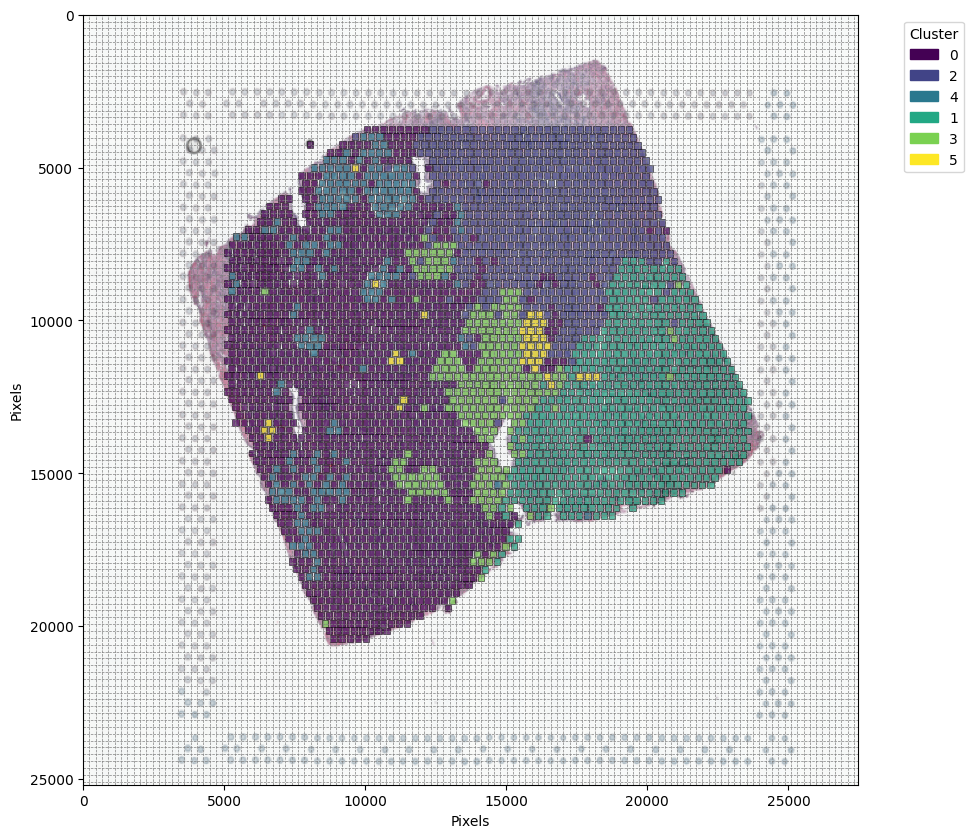

In [16]:
# Ground Truth Visualization
print("=== VISUALIZING GROUND TRUTH ===")

from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

image_path = "spatial_acinar/tissue_lowres_image.png"

# Create dataframe with ground truth labels and spatial coordinates
df_ground_truth_viz = df_eval[['Patch_X', 'Patch_Y', 'label']].copy()
print(f"Ground Truth: {len(df_ground_truth_viz)} patches with {len(set(df_ground_truth_viz['label']))} clusters")
print(f"Ground truth clusters: {sorted(set(df_ground_truth_viz['label']))}")

visualize_tissue_image_with_samples_color_labels(image_path, df_ground_truth_viz, 27472, 25188)

=== VISUALIZING STANDARD MODEL PREDICTIONS ===
Model: Standard DNN
ARI Score: 0.0728
Predictions: 3043 patches with 6 clusters
Predicted clusters: [0, 1, 2, 3, 4, 5]
Features: Original high-dimensional (1536 dimensions)


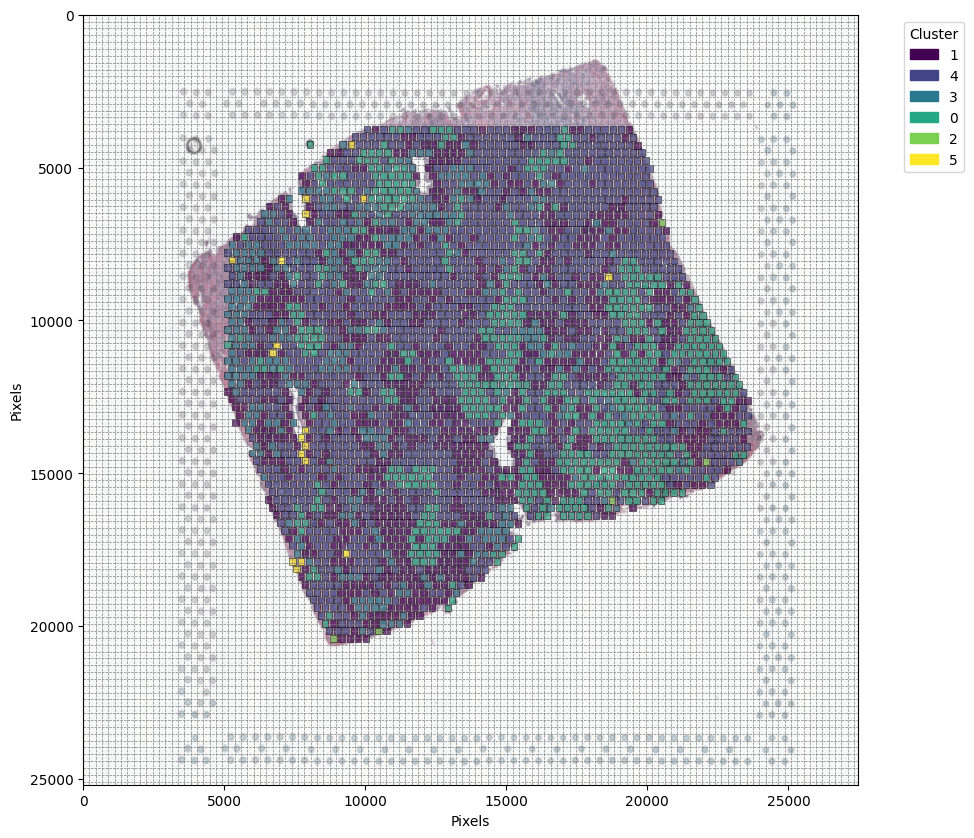

In [17]:
# Standard Model Predictions Visualization
print("=== VISUALIZING STANDARD MODEL PREDICTIONS ===")

from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

image_path = "spatial_acinar/tissue_lowres_image.png"

# Use standard model (no PCA)
best_std_predictions = std_eval_labels
best_std_name = "Standard DNN"
best_std_ari = simple_results['std_no_pca']['ari']

# Create dataframe with standard model predictions and spatial coordinates
df_std_predictions_viz = df_eval[['Patch_X', 'Patch_Y']].copy()
df_std_predictions_viz['label'] = best_std_predictions

print(f"Model: {best_std_name}")
print(f"ARI Score: {best_std_ari:.4f}")
print(f"Predictions: {len(df_std_predictions_viz)} patches with {len(set(best_std_predictions))} clusters")
print(f"Predicted clusters: {sorted(set(best_std_predictions))}")
print(f"Features: Original high-dimensional ({embedding_dim} dimensions)")

visualize_tissue_image_with_samples_color_labels(image_path, df_std_predictions_viz, 27472, 25188)

=== VISUALIZING CONFIDENCE MODEL PREDICTIONS ===
Model: Confidence-weighted DNN
ARI Score: 0.0491
Predictions: 3043 patches with 6 clusters
Predicted clusters: [0, 1, 2, 3, 4, 5]
Features: Original high-dimensional (1536 dimensions)


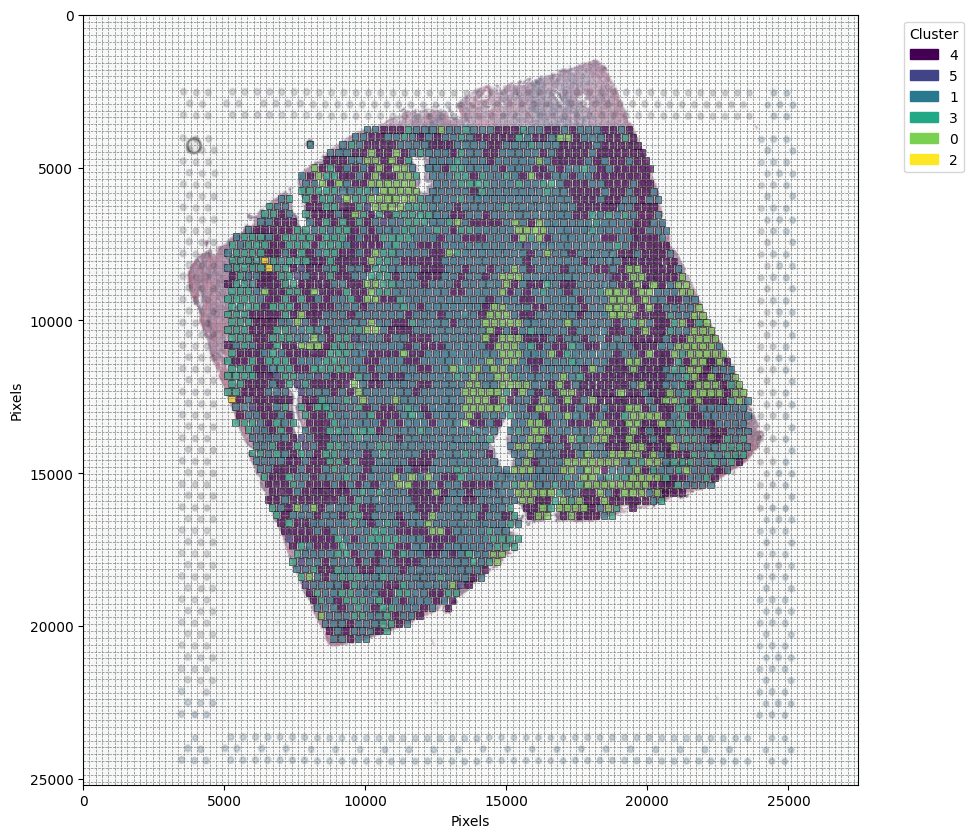


=== VISUALIZATION COMPARISON SUMMARY ===
Ground Truth: 6 acinar tissue clusters
Standard Model (Standard DNN): ARI = 0.0728
Confidence Model (Confidence-weighted DNN): ARI = 0.0491
Best Overall Model: Standard DNN

✓ All models trained on original 1536-dimensional features (no PCA)
✓ All visualizations show cross-domain evaluation results (adenocarcinoma → acinar)


In [18]:
# Confidence Model Predictions Visualization
print("=== VISUALIZING CONFIDENCE MODEL PREDICTIONS ===")

from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

image_path = "spatial_acinar/tissue_lowres_image.png"

# Use confidence model (no PCA)
best_conf_predictions = conf_eval_labels
best_conf_name = "Confidence-weighted DNN"
best_conf_ari = simple_results['conf_no_pca']['ari']

# Create dataframe with confidence model predictions and spatial coordinates
df_conf_predictions_viz = df_eval[['Patch_X', 'Patch_Y']].copy()
df_conf_predictions_viz['label'] = best_conf_predictions

print(f"Model: {best_conf_name}")
print(f"ARI Score: {best_conf_ari:.4f}")
print(f"Predictions: {len(df_conf_predictions_viz)} patches with {len(set(best_conf_predictions))} clusters")
print(f"Predicted clusters: {sorted(set(best_conf_predictions))}")
print(f"Features: Original high-dimensional ({embedding_dim} dimensions)")

visualize_tissue_image_with_samples_color_labels(image_path, df_conf_predictions_viz, 27472, 25188)

print(f"\n=== VISUALIZATION COMPARISON SUMMARY ===")
print(f"Ground Truth: {len(set(df_eval['label']))} acinar tissue clusters")
print(f"Standard Model ({best_std_name}): ARI = {best_std_ari:.4f}")
print(f"Confidence Model ({best_conf_name}): ARI = {best_conf_ari:.4f}")
print(f"Best Overall Model: {best_conf_name if best_conf_ari > best_std_ari else best_std_name}")
print(f"\n✓ All models trained on original {embedding_dim}-dimensional features (no PCA)")
print(f"✓ All visualizations show cross-domain evaluation results (adenocarcinoma → acinar)")